# Report

As the assignment asks to report only the final test outputs of 10 runs and as test performance doesn't help to improve following training I only recorded the test output at the final run

Whe we set temperature low in boltzmann exploration, we make the algorithm less exploratory and when the temperature increases, it becomes more exploratory.

I ran the experiments for temperature 0.1,0.5 and 1. Used 0.2,0.6 and 1 alpha values. 

I evaulated the parameter based on the final run of the algorithms. I found them to perform best in evaluation period (at the evaluation/test uses learnt policy greedily) when training temperature is set at 0.5. Means it's not too greedy and neither to exploratory. 

I have also found the Qlearning and SARSA to perfrom best for alpha 0.6. Higher learning rate makes the variance high in SARSA and Expected SARA algorithm solves that issue and seems from the performance as well that Expected SARSA performs best at higher learning rate due to variance reduction.

In the learning curve due to proper tuning of the parameter all three performs similar by the end of training.

(Ran algorithm for 10 different alphas but as the report requies only three I compared for 3 only.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
from cliff_walking_org import CliffWalkingEnv
import random
import seaborn as sns
import pandas as pd
import os

In [2]:
class Agent(object):

    def __init__(self, env, policy, gamma, temp, alpha, epsilon=0.1):
        self.env = env
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.temp = temp
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        if policy == 'Boltzmann_Exploration':
            self.policy = self.Boltzmann_Exploration
        elif policy == 'egreedy_policy':
            self.policy = self.egreedy_policy
        #np.random.seed(seed=1)
        
    def Boltzmann_Exploration(self, Q_val):
        prob = np.exp(Q_val / self.temp) / np.sum(np.exp(Q_val / self.temp))
        action = np.random.choice(len(Q_val), 1, p=prob)[0]
        return action, prob
        
    def Qlearning(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Repeat for each step of episode
            while not done:
                # Choose action: Use Boltzmann_Exploration
                action, _ = self.policy(self.Q[state, :])
                #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
                #action = self.egreedy_policy(self.Q[state, :])
            
                
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                td_target = reward + self.gamma * np.max(self.Q[next_state, :])
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q
    
    def SARSA(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Choose action: Use Boltzmann_Exploration
            action, _ = self.policy(self.Q[state, :])
            #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
            #action = self.egreedy_policy(self.Q[state, :])

            # Repeat for each step of episode
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                next_action,_ = self.policy(self.Q[next_state, :])
                #next_action,_ = self.Boltzmann_Exploration(self.Q[next_state, :])
                #next_action = self.egreedy_policy(self.Q[next_state, :])

                td_target=reward + self.gamma*self.Q[next_state,next_action]
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                # a'=a
                action = next_action
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q
    
    def Expected_SARSA(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Choose action: Use Boltzmann_Exploration
            #action, _ = self.Boltzmann_Exploration(self.Q[state, :])
            action, _ = self.policy(self.Q[state, :])


            # Repeat for each step of episode
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                # compute TD target:
                #next_action, prob = self.Boltzmann_Exploration(self.Q[next_state, :])
                next_action, prob = self.policy(self.Q[next_state, :])

                td_target=reward + self.gamma*np.sum(prob*self.Q[next_state,:])
                td_error = td_target - self.Q[state, action]
                # Q update
                self.Q[state, action] = self.Q[state, action] + self.alpha * td_error
                # s'=s
                state = next_state
                # a'=a
                action = next_action
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards, self.Q
    
    def reset(self):
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        
        
    def eval_(self, episodes):
        rewards = []
        for episode in range(episodes):
            # initialize state,S
            state = self.env.reset()
            done = False
            episodic_reward = 0
            # Repeat for each step of episode
            while not done:
                #env.render()
                #time.sleep(0.5)
                # take greedy action
                action = np.argmax(self.Q[state, :])
                next_state, reward, done, _ = self.env.step(action)
                # s'=s
                state = next_state
                episodic_reward += reward

            rewards.append(episodic_reward)
        return rewards




In [3]:
def run_experiment (env,policy,gamma,alphas,temp):
    print('Running Experient on: {}'.format(env))
    stack = {}
    
    stack_episodic_reward1 = np.zeros(len(alphas))
    stack_episodic_reward2 = np.zeros(len(alphas))
    stack_episodic_reward3 = np.zeros(len(alphas))
    
    stack_eval_reward1 = np.zeros(len(alphas))
    stack_eval_reward2 = np.zeros(len(alphas))
    stack_eval_reward3 = np.zeros(len(alphas))

    for run in range (10):
        print('Running Experiment: {} with temp: {}'.format(run, temp))

        mean_episodic_reward1 = []
        mean_episodic_reward2 = []
        mean_episodic_reward3 = []
        eval_reward1 = []
        eval_reward2 = []
        eval_reward3 = []

        for alpha in alphas:
            
            Qlearning = Agent(env,policy,gamma, temp, alpha=alpha, epsilon=0.1)
            Qlearning.reset()
            SARSA = Agent(env, policy, gamma, temp, alpha=alpha, epsilon=0.1)
            SARSA.reset()
            Expected_SARSA = Agent(env, policy, gamma, temp, alpha=alpha, epsilon=0.1)
            Expected_SARSA.reset()

            for segment in range(100):
                # episodic rewards = cumulative rewards 10 episodes 
                # eval_reward = reward for single evaluation step
                episodic_rewards1,Q1 = Qlearning.Qlearning(episodes=10)
                episodic_rewards2,Q2 = SARSA.SARSA(episodes=10)
                episodic_rewards3,Q3 = Expected_SARSA.Expected_SARSA(episodes=10)
            
            # we get final evaluation result for different alphas
            eval_reward1.append(Qlearning.eval_(episodes=1))
            eval_reward2.append(SARSA.eval_(episodes=1))
            eval_reward3.append(Expected_SARSA.eval_(episodes=1))
            #print(eval_reward3)
            # stack mean of last 10 training reward for different alpha
            mean_episodic_reward1.append(np.mean(episodic_rewards1))
            mean_episodic_reward2.append(np.mean(episodic_rewards2))
            mean_episodic_reward3.append(np.mean(episodic_rewards3))


        stack_episodic_reward1+=mean_episodic_reward1
        stack_episodic_reward2+=mean_episodic_reward2
        stack_episodic_reward3+=mean_episodic_reward3
        
        stack_eval_reward1+=np.array(eval_reward1).ravel()
        stack_eval_reward2+=np.array(eval_reward2).ravel()
        stack_eval_reward3+=np.array(eval_reward3).ravel()


        
    stack['Qlearning'] = stack_episodic_reward1/(run+1)
    stack['SARSA'] = stack_episodic_reward2/(run+1)
    stack['Expected_SARSA'] = stack_episodic_reward3/(run+1)
    
    stack['Qeval']=stack_eval_reward1/(run+1)
    stack['Seval']=stack_eval_reward2/(run+1)
    stack['Expectedeval']=stack_eval_reward3/(run+1)
    
    return stack

In [ ]:
alphas = np.linspace(0.1,1,10)
#alphas = [0.2, 0.6, 1]
gamma = 0.99  # disocunt factor
env = gym.make('Taxi-v2')
#env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temps = 0.5
results1 = run_experiment (env,policy,gamma,alphas,temps)

results1 = pd.DataFrame(results1)
results1.to_csv('results1.csv')

In [ ]:
alphas = np.linspace(0.1,1,10)
#alphas = [0.2, 0.6, 1]
gamma = 0.99  # disocunt factor
env = gym.make('Taxi-v2')
#env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temps = 0.1
results2 = run_experiment (env,policy,gamma,alphas,temps)
results2 = pd.DataFrame(results2)
results2.to_csv('results2.csv')

In [ ]:
alphas = np.linspace(0.1,1,10)
#alphas = [0.2, 0.6, 1]
gamma = 0.99  # disocunt factor
env = gym.make('Taxi-v2')
#env = CliffWalkingEnv()
policy ='Boltzmann_Exploration'
temps = 1
results3 = run_experiment (env,policy,gamma,alphas,temps)
results3 = pd.DataFrame(results3)
results3.to_csv('results3.csv')

# Load saved Data

In [36]:
temps = [0.5,0.1,1.0]
alphas = np.linspace(0.1,1,10)
data = []
for i in range(3):
    data.append(pd.read_csv('results{}.csv'.format(i+1)))


# (1) Performance Comparison of  During Final Training

averaged over the last 10 training episodes and the 10 runs

In [85]:
def get_figure1 (data,alphas,temps,algo):
    plt.figure(figsize=(10,6))
    for i in range(len(temps)):
        plt.plot(alphas[1::4], data[i][1::4]['{}'.format(algo)], label='Temp {}'.format(temps[i]))
        plt.legend()
    t = 'Final Training Performance of {} on different Temp'.format(algo)
    plt.title(t)
    plt.ylabel('Average Rewards over last 10 training for 10 runs')
    plt.xlabel('Learning rate')
    plt.legend()
    #plt.show()
    plt.savefig('figures/{}.pdf'.format(t))


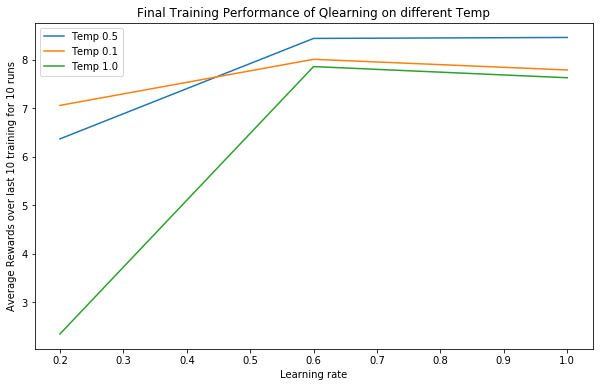

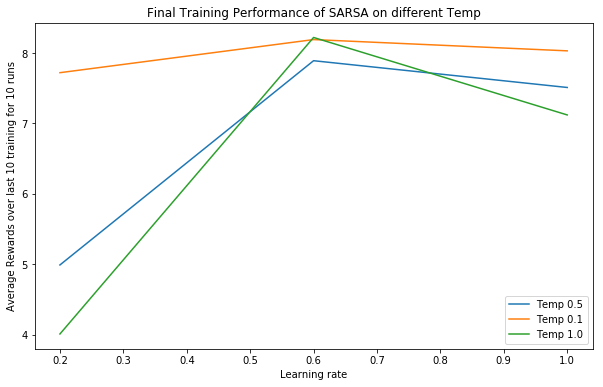

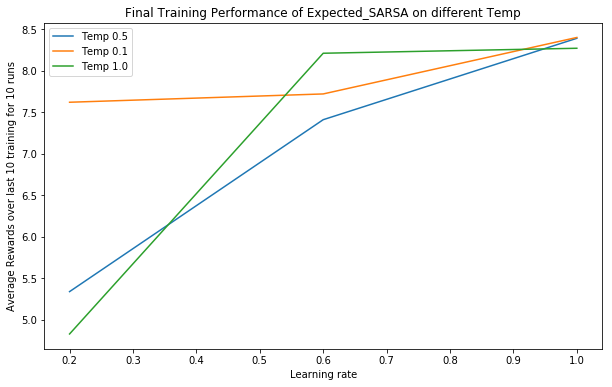

In [86]:
get_figure1(data,alphas,temps,algo='Qlearning')
get_figure1(data,alphas,temps,algo='SARSA')
get_figure1(data,alphas,temps,algo='Expected_SARSA')

# (2) Performance Comparison During Final Testing

In [83]:
def get_figure2 (data,alphas,temps,algo):
    
    
    plt.figure(figsize=(10,6))
    for i in range(len(temps)):
        plt.plot(alphas[1::4], data[i][1::4]['{}'.format(algo)], label='Temp {}'.format(temps[i]))
    t = 'Final Testing Performance of {} on different Temp'.format(algo)
    plt.title(t)
    plt.ylabel('Average Rewards over final testing fo 10 runs')
    plt.xlabel('Learning rate')
    plt.legend()
    
    #plt.show()
    plt.savefig('figures/{}.pdf'.format(t))

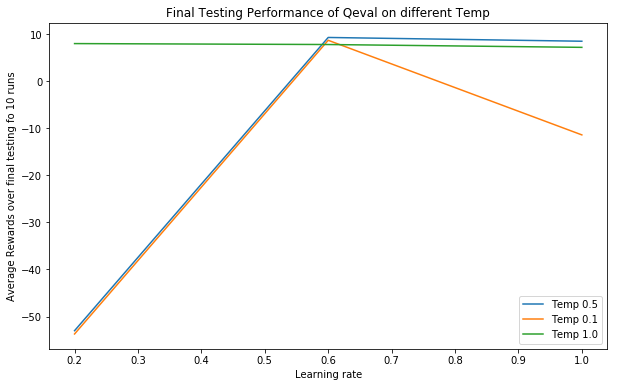

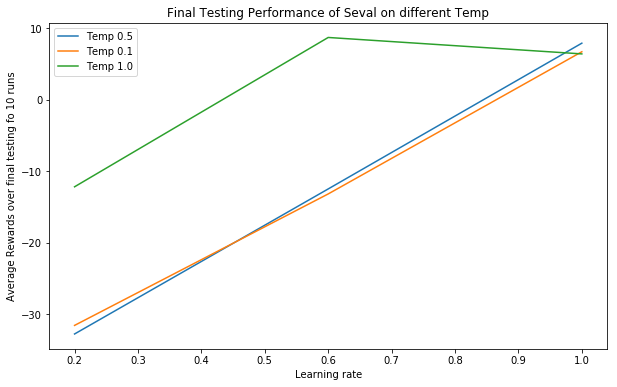

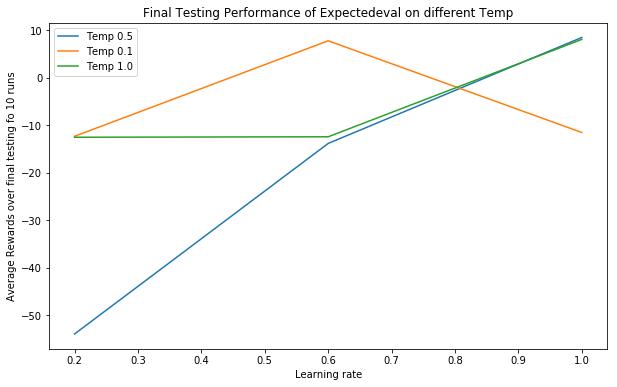

In [84]:
get_figure2(data,alphas,temps,algo='Qeval')  # Qlearning during evaluation
get_figure2(data,alphas,temps,algo='Seval')  # SARSA during evaluation
get_figure2(data,alphas,temps,algo='Expectedeval') # Expected SARSA during evaluation

In [5]:
def get_best_param(results,datatype, alphas, temps):  
    max_r = -100
    loc = datatype
    for i in range(3):
        
        if data[i]['{}'.format(loc)][1::4].max(axis=0) > max_r:
            best_alpha = alphas[data[i]['{}'.format(loc)][1::4].idxmax(axis=0)]
            max_r = data[i]['{}'.format(loc)][1::4].max(axis=0)
            best_temp = temps[i]
    return best_alpha, max_r ,best_temp

In [6]:
def data_for_learning_curve(alpha,temp,algo):
    print('Algorithm: {}'.format(algo))
    #final_stack = {}
    gamma = 0.99  # disocunt factor
    env = gym.make('Taxi-v2')
    #total_rewards = pd.DataFrame()
    total_rewards = []
    policy ='Boltzmann_Exploration'
    for run in range(10):
        print('Running Experiment No: {}'.format(run))
        episodic_reward = []
        if algo == 'Qlearning':
            Qlearning = Agent(env,policy,gamma, temp, alpha, epsilon=0.1)    
            episodic_reward,Q1 = Qlearning.Qlearning(episodes=1000)
            
        elif algo == 'SARSA':
            SARSA = Agent(env,policy,gamma, temp, alpha, epsilon=0.1)    
            episodic_reward,Q1 = SARSA.SARSA(episodes=1000)
        
        elif algo == 'Expected_SARSA':
            Expected_SARSA = Agent(env,policy,gamma, temp, alpha, epsilon=0.1)    
            episodic_reward,Q1 = Expected_SARSA.Expected_SARSA(episodes=1000)

        total_rewards.append(episodic_reward)    
    return total_rewards

In [26]:
def plot_final_graph(stack,alphas,temps,algos,fig_name):
    colors = sns.color_palette('colorblind', n_colors=3)
    timestep = np.linspace(0,1000,1000)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    for algo,color,alpha,temp in zip(algos,colors,alphas,temps):
        total_rewards = stack['{}'.format(algo)]
        data = pd.DataFrame(total_rewards).T.rolling(10, min_periods=10).mean()
        mean = data.mean(axis=1)
        std = data.std(axis=1)
        plt.plot(timestep,mean,color=color,linewidth=1.5, label='algo:{} | alpha:{} | temp:{}'.format(algo,alpha,temp)) 
        ax.fill_between(timestep,mean+std,mean-std,alpha=0.1,edgecolor=color, facecolor=color)
    plt.ylim(-200,25)
    x_label = 'Iterations'
    y_label = 'Episodic Rewards'
    #title = ('for alpha: {} and temperature: {}').format(alpha,temp)   
    ax.legend(loc='lower right', prop={'size' : 5})
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    #ax.set_title(title)
    
    plt.legend()
    plt.show()
    fig.savefig('figures/{}.pdf'.format(fig_name))

In [22]:
Q_alpha, _ , Q_temp = get_best_param(results=data,datatype='Qeval',alphas=alphas,temps=temps)
alpha = np.array([Q_alpha])
Q_data = data_for_learning_curve(Q_alpha,Q_temp,algo='Qlearning')

Algorithm: Qlearning
Running Experiment No: 0
Running Experiment No: 1
Running Experiment No: 2
Running Experiment No: 3
Running Experiment No: 4
Running Experiment No: 5
Running Experiment No: 6
Running Experiment No: 7
Running Experiment No: 8
Running Experiment No: 9


In [23]:
S_alpha, _ , S_temp = get_best_param(results=data,datatype='Seval',alphas=alphas,temps=temps)
alpha = np.array([S_alpha])
S_data = data_for_learning_curve(S_alpha,S_temp,algo='SARSA')

Algorithm: SARSA
Running Experiment No: 0
Running Experiment No: 1
Running Experiment No: 2
Running Experiment No: 3
Running Experiment No: 4
Running Experiment No: 5
Running Experiment No: 6
Running Experiment No: 7
Running Experiment No: 8
Running Experiment No: 9


In [21]:
ExpectedS_alpha, _ , ExpectedS_temp = get_best_param(results=data,datatype='Expectedeval',alphas=alphas,temps=temps)
alpha = np.array([ExpectedS_alpha])
ExpectedS_data = data_for_learning_curve(ExpectedS_alpha,ExpectedS_temp,algo='Expected_SARSA')

Algorithm: Expected_SARSA
Running Experiment No: 0
Running Experiment No: 1
Running Experiment No: 2
Running Experiment No: 3
Running Experiment No: 4
Running Experiment No: 5
Running Experiment No: 6
Running Experiment No: 7
Running Experiment No: 8
Running Experiment No: 9


In [24]:
final_stack = {}
final_stack['Qlearning'] = Q_data
final_stack['SARSA'] = S_data
final_stack['Expected_SARSA'] = ExpectedS_data

# (3) Learning curve

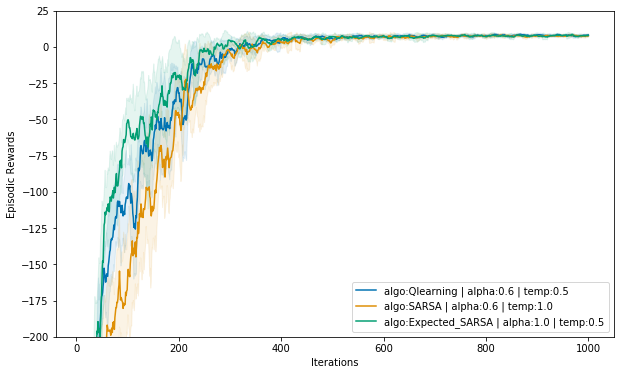

In [27]:
algos = ['Qlearning','SARSA','Expected_SARSA']
alphas =  np.array([Q_alpha, S_alpha, ExpectedS_alpha])
temps = [Q_temp, S_temp, ExpectedS_temp]
plot_final_graph(final_stack,alphas,temps,algos,fig_name='Learning Curve Comparison')